# Regularization

What is regularization? And why do we need to regularize?

**Regularization** refers to the different kind of techniques used to prevent the model from overfitting or underfitting. But what does overfitting or underfitting mean? And why do they happen?

Simply put, overfitting or underfitting happens when the model fails to capture (or model) the key features of our data. When this happens, the model will fail to generalize to new data (such as our test set), and performance drops considerably.

**Key indicators and potential reasons when a model overfits/underfits:**

* **Underfitting** - $\uparrow$ train loss, $\uparrow$ test loss ($\downarrow$ train acc, $\downarrow$ test acc)

    * the model did not have enough training
    * model is too simple vs task/data complexity
    * data is too "noisy"
    * data is not enough
    
    
* **Overfitting** - $\downarrow$ train loss, $\uparrow$ test loss ($\uparrow$ train acc, $\downarrow$ test acc)

    * too much training
    * model is too complex for a given (simple) task
    * very little data "noise" that it encourage train set memorization than learning

## Data Augmentation as a Regularizer

Many ways to regularize, which involves either modifying our data or the model (or apply different techniques to both), for our model to fit well to our data.

**Data Augmentation**, which involves applying _transformations_ to our data (and hence augmenting it), is one of them. Not only can we introduce noise to potentially avoid model overfitting, we can also use it to generate even more data to avoid underfitting.

### Exploring common/simple data augmentation techniques with PyTorch

In this section, we'll be exploring some common data augmentation techniques with PyTorch. For this example, we will simply be using a toy image for this section.

Follow [this link](https://pytorch.org/vision/main/transforms.html) to see various data transformations available in PyTorch.

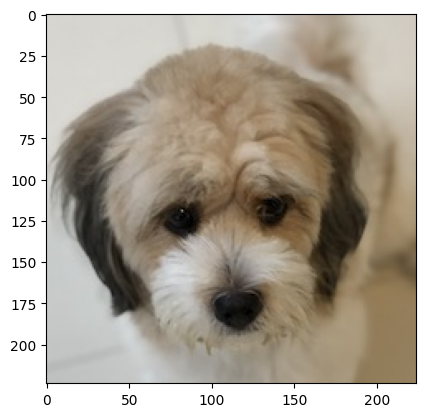

In [1]:
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open('./resources/aki_dog.jpg')
plt.imshow(image)
plt.show()

In [2]:
import torchvision.transforms as T

**Random Flipping**

The probability `p` will determine the chances of the image of getting flipped. In this example, we set `p=1.0` to force the image to flip. In practice, we set `p` depending on various factors.

Note that random transformations can cause your results to vary in eacb run, unless for example you set `p=1.0`. The same is true for other random transformations.

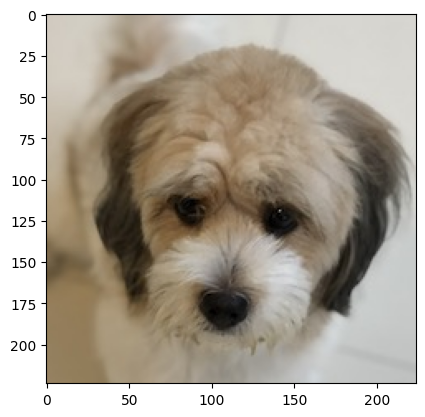

In [3]:
plt.imshow(T.RandomHorizontalFlip(p=1.0)(image))
plt.show()

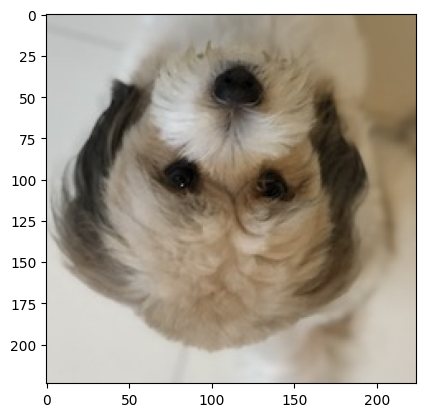

In [4]:
plt.imshow(T.RandomVerticalFlip(p=1.0)(image))
plt.show()

**Rotation**

You can use `RandomRotation` and specify the `(min,max)` range of angles. Alternatively, simply use [`rotate`](https://pytorch.org/vision/stable/generated/torchvision.transforms.functional.rotate.html#torchvision.transforms.functional.rotate) to rotate using a fixed angle (counter-clockwise)

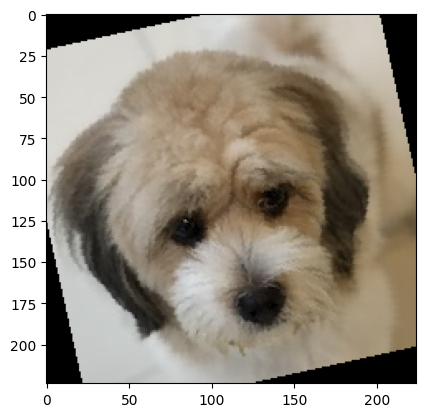

In [5]:
plt.imshow(T.RandomRotation((0,90))(image))
plt.show()

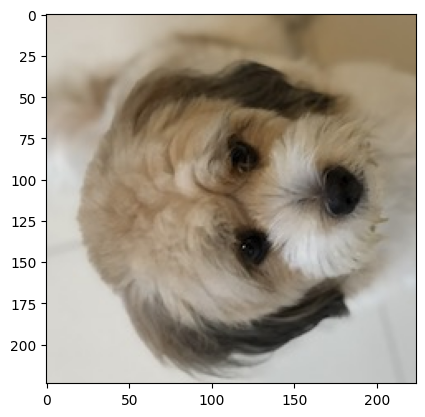

In [6]:
plt.imshow(T.functional.rotate(image, angle=90))
plt.show()

**Padding**

Sometimes, resizing an image can cause you to lose some important features. Or, in other cases, it's possible that the important features can be found in corners/edges of an image instead. Hence, we apply padding on our image.

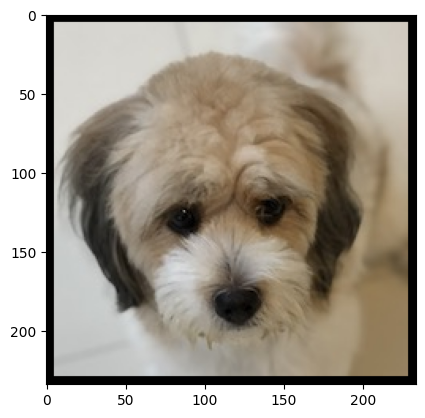

In [7]:
image_padded = T.Pad(5)(image)
plt.imshow(image_padded)
plt.show()

In [8]:
print(image.size, image_padded.size)

(224, 224) (234, 234)


**Crop**

There are two ways to crop an image: `CenterCrop`, which crops from the center of an image, and `RandomCrop`, which crops randomly. `CenterCrop` is more commonly used, especially in classification tasks where we normally don't care about the image borders (which are, more often, just background).

That said, be sure to inspect your data before cropping regardless, as this can cause you to lose relevant features (esp if said features, or objects are found in edges).

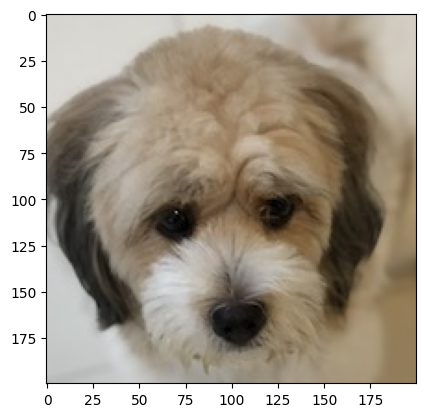

In [9]:
plt.imshow(T.CenterCrop(200)(image))
plt.show()

**Gaussian Blur**

Blurs the image to force the model to learn important patterns in an image.

For example, after blurring the image as shown below, the features that gets more pronounced are the eyes, ears, and nose of the dog. So when you want the model to classify whether the image is a dog or not dog, it will look for these features.

On the other hand, there is also a good chance for this to cause model confusion instead (eg. bear vs dog, which can have the same features). You have to set the appropriate `kernel_size` and `sigma` depending on your data.

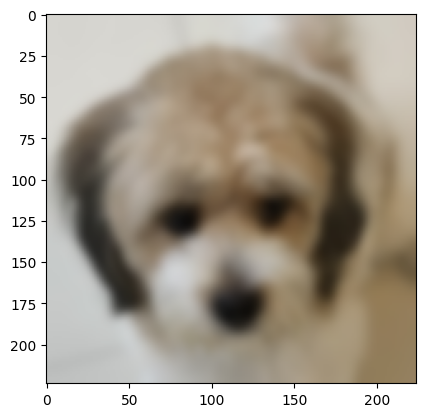

In [10]:
plt.imshow(T.GaussianBlur(kernel_size=(105,125), sigma=(3))(image))
plt.show()

There are many other techniques that can be used to augment your data, such as adding noisee, among other things. Full list can again be [found here](https://pytorch.org/vision/main/transforms.html).

## Train/Test a model with Data Augmentation

In this section, we will train an CNN model with augmented data, then see its performance. The model trained without data augmentation [can be found here](https://github.com/izzajalandoni/Deep-Learning-Helper/blob/main/Deep_Learning/BuildingBlocks/cnn_demo.ipynb).

In [11]:
import datasets

trainset = datasets.load_dataset('cifar10', split='train')
testset = datasets.load_dataset('cifar10', split='test')

Found cached dataset cifar10 (/home/izza/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)
Found cached dataset cifar10 (/home/izza/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)


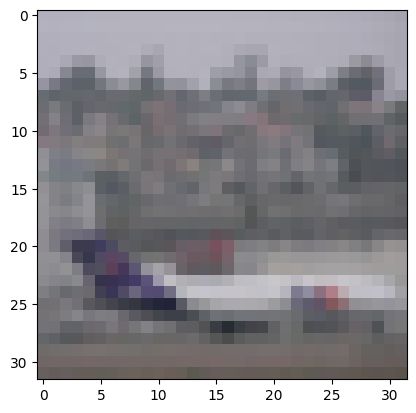

In [12]:
plt.imshow(trainset[0]['img'])
plt.show()

Rather than simply converting our image `ToTensor()`, we include other transformations as well. In this example, we used `AutoAugment` from [this paper](https://arxiv.org/pdf/1805.09501.pdf).

In [13]:
augment_data = True

augment = T.Compose([
    T.AutoAugment(),
    T.ToTensor()
])

tensor = T.ToTensor()

# Different transformation functions
def augment_input(data):
    data['img'] = [augment(image.convert('RGB')) for image in data['img']]
    return data

def tensor_input(data):
    data['img'] = [tensor(image.convert('RGB')) for image in data['img']]
    return data

# Only augment the trainset, testset should only be ToTensor()
if augment_data:
    trainset.set_transform(transform=augment_input)
else:
    trainset.set_transform(transform=tensor_input)
testset.set_transform(transform=tensor_input)

In [14]:
import torch

trainloader = torch.utils.data.DataLoader(trainset, num_workers=8, batch_size=4)
testloader = torch.utils.data.DataLoader(testset, num_workers=8, batch_size=4)

No changes done to our model.

In [15]:
import pytorch_lightning as pl
import torch.nn as nn
import torchmetrics as tm

from matplotlib import pyplot as plt

labels = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer",
          5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}

class CNN(pl.LightningModule):
    def __init__(self, num_channel, num_class):
        super().__init__()
        self.num_channel = num_channel
        self.num_class = num_class

        self.conv1 = nn.Conv2d(num_channel, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.pool = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(128*4*4, 128)
        self.fc2 = nn.Linear(128, num_class)
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)
    
    def display(self, x, y_p, y):
        num_outputs = x.shape[0]
        y_p = torch.argmax(y_p, dim=1)

        for i in range(num_outputs):
            image = x[i].permute((1,2,0)).cpu()
            plt.imshow(image)
            plt.show()
            print("Ground Truth: {}[{}], Predicted: {}[{}]".format(
                labels[y[i].item()], y[i], labels[y_p[i].item()], y_p[i]))
    
    def training_step(self, batch, batch_idx):
        x,y = batch['img'], batch['label']
        y_p = self.forward(x)
        loss = self.criterion(y_p, y)
        
        # Since this is per batch, we can sum correct predictions first
        acc = torch.argmax(y_p, dim=1).eq(y).sum()
        acc = acc/y.shape[0]
        
        return {"loss": loss, "acc": acc}
    
    def training_epoch_end(self, outputs):
        epoch_loss = torch.stack([out['loss'] for out in outputs]).mean()
        epoch_acc = torch.stack([out['acc'] for out in outputs]).mean()
        
        print("Epoch {}, Loss: {}, Accuracy: {}".format(self.current_epoch, epoch_loss, epoch_acc))
    
    def test_step(self, batch, batch_idx):
        x,y = batch['img'], batch['label']
        y_p = self.forward(x)
        
        if batch_idx == 0:
            self.display(x, y_p, y)
        
        # Calculate accuracy
        acc = torch.argmax(y_p, dim=1).eq(y).sum()
        acc = acc/y.shape[0]
        return {"acc": acc}
    
    def test_epoch_end(self, outputs):
        test_acc = torch.stack([out['acc'] for out in outputs]).mean()
        print("Test Accuracy: {}".format(test_acc))
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

We extract info about our data.

In [16]:
import numpy as np

batch = next(iter(testloader))
b,c,h,w = batch['img'].shape
num_class = len(np.unique(testset[:]['label']))

Training.

In [ ]:
num_epochs = 5

model = CNN(c, num_class)
trainer = pl.Trainer(devices="auto", accelerator="auto",
                    max_epochs=num_epochs)
trainer.fit(model, trainloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | conv1     | Conv2d           | 896   
1 | conv2     | Conv2d           | 18.5 K
2 | conv3     | Conv2d           | 73.9 K
3 | pool      | MaxPool2d        | 0     
4 | relu      | ReLU             | 0     
5 | fc1       | Linear           | 262 K 
6 | fc2       | Linear           | 1.3 K 
7 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
356 K     Trainable params
0         Non-trainable params
356 K     Total params
1.427     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Epoch 0, Loss: 1.8128037452697754, Accuracy: 0.3422999978065491
Epoch 1, Loss: 1.5143911838531494, Accuracy: 0.4691599905490875
Epoch 2, Loss: 1.389915108680725, Accuracy: 0.5158399939537048
Epoch 3, Loss: 1.3223601579666138, Accuracy: 0.537880003452301


Testing.

In [ ]:
trainer.test(model, testloader)

There can be a tradeoff between robustness vs convergence speed, i.e. more training iterations might be required depending on the augmentations you used.

Try applying some techniques here in conjunction with model regularization to attain higher results.